## xgboost 多类别分类

参考：
- [ xgboost入门与实战（实战调参篇）](http://blog.csdn.net/sb19931201/article/details/52577592)

数据： MNIST

## 基本模型

1.导入相关的包

In [1]:
import numpy as np
import pandas as pd 
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time

2.数据分析

In [2]:
# 导入数据,一共有 54 列数据，其中最后一列表示 label（评论数）
df_train_dataset = pd.read_csv('data/MNIST/train.csv', delimiter=',')
df_test_dataset = pd.read_csv('data/MNIST/test.csv', delimiter=',')
print('sample df_train_dataset = %d' % len(df_train_dataset))
print('sample df_test_dataset = %d' % len(df_test_dataset))
df_train_dataset.head()

sample df_train_dataset = 42000
sample df_test_dataset = 28000


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# 测试数据,直接从训练集中划分部分数据出来作为验证集
# kaggle 上面下载的测试集和是没有标签的
X = df_train_dataset.values[:, 1:]
y = df_train_dataset.values[:, 0]
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

### 输入数据的形式
处理成 xgb.DMatrix 格式

3.训练模型

[XGBoost-Python完全调参指南-参数解释篇](http://blog.csdn.net/wzmsltw/article/details/50994481)

objective [ default=reg:linear ] 
定义学习任务及相应的学习目标，可选的目标函数如下：
- “reg:linear” –线性回归。
- “reg:logistic” –逻辑回归。
- “binary:logistic” –二分类的逻辑回归问题，输出为概率。
- “binary:logitraw” –二分类的逻辑回归问题，输出的结果为wTx。
- “count:poisson” –计数问题的poisson回归，输出结果为poisson分布。
- 在poisson回归中，max_delta_step的缺省值为0.7。(used to safeguard optimization)
- “multi:softmax” –让XGBoost采用softmax目标函数处理多分类问题，同时需要设置参数num_class（类别个数）
- “multi:softprob” –和softmax一样，但是输出的是ndata * nclass的向量，可以将该向量reshape成ndata行nclass列的矩阵。每行数据表示样本所属于每个类别的概率。
- “rank:pairwise” –set XGBoost to do ranking task by minimizing the pairwise loss

In [4]:
tic = time.time()
model = XGBClassifier(n_estimators=100, objective='multi:softmax', silent=False, max_depth=5, subsample=0.8, colsample_bytree=0.8, n_jobs=12)  # 多分类的问题
model.fit(X_train, y_train)
print('time cost %gs' % (time.time() - tic))

time cost 127.155s


In [5]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.20%


In [6]:
sample_id = 10
y_prob0 = model.predict_proba(X_test[sample_id].reshape([1,-1]))
print('y_prob0=', y_prob0)

('y_prob0=', array([[  2.47340387e-04,   1.19861557e-04,   7.48016464e-04,
          1.05194177e-03,   4.22338635e-04,   5.50034968e-03,
          9.90204215e-01,   1.55227215e-04,   1.25316205e-03,
          2.97537714e-04]], dtype=float32))


In [7]:
y_leaf = model.apply(X_test)
print('y_leaf.shape=', y_leaf.shape)
# 树的棵数
min_id = np.min(y_leaf, axis=0)
max_id = np.max(y_leaf, axis=0)
min_max_id = zip(min_id, max_id)
print('min_max_id=%s' % str(min_max_id))

('y_leaf.shape=', (13860, 1000))
min_max_id=[(22, 60), (12, 56), (24, 58), (18, 60), (31, 62), (12, 52), (29, 60), (14, 46), (31, 62), (30, 60), (27, 60), (31, 62), (21, 58), (20, 60), (24, 60), (12, 46), (21, 56), (31, 62), (31, 62), (12, 56), (27, 58), (13, 48), (26, 60), (20, 56), (26, 60), (12, 50), (26, 56), (22, 60), (31, 62), (13, 50), (27, 60), (31, 62), (31, 62), (20, 60), (31, 62), (12, 48), (18, 52), (31, 62), (16, 60), (13, 52), (21, 58), (19, 56), (20, 60), (21, 58), (31, 62), (12, 52), (21, 52), (20, 56), (31, 62), (24, 54), (21, 54), (19, 52), (27, 58), (31, 62), (31, 62), (20, 52), (18, 52), (21, 58), (31, 62), (29, 58), (24, 56), (20, 58), (29, 60), (22, 60), (31, 62), (20, 50), (18, 56), (21, 56), (31, 62), (13, 50), (21, 56), (23, 52), (24, 56), (31, 62), (31, 62), (18, 54), (25, 52), (21, 56), (31, 62), (14, 54), (24, 54), (12, 52), (28, 60), (31, 62), (31, 62), (22, 56), (17, 52), (22, 60), (20, 60), (25, 58), (21, 56), (27, 56), (28, 58), (22, 60), (31, 62), (18, 

In [8]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=12, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=0.8)

>**Q**：这里一共有 10 个类别，设置了 softmax 类型的目标函数。一共迭代了 100 次，结果却有 1000 棵数。也就是说每次学习 10 棵数，分别表示 10 个类别，每棵树都是一个 二分类？

>A:[多分类，基于one vs all的方式训练多棵。](多分类，基于one vs all的方式训练多棵。)

### 绘制树的结构
[如何画XGBoost里面的决策树(decision tree)](https://zhuanlan.zhihu.com/p/28324798)

In [9]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

In [10]:
plot_tree(model, num_trees=0)
plt.savefig('figs/m_tree1.png',dpi=500)
plot_tree(model, num_trees=8)
plt.savefig('figs/m_tree8.png',dpi=500)

In [11]:
from IPython.display import Image

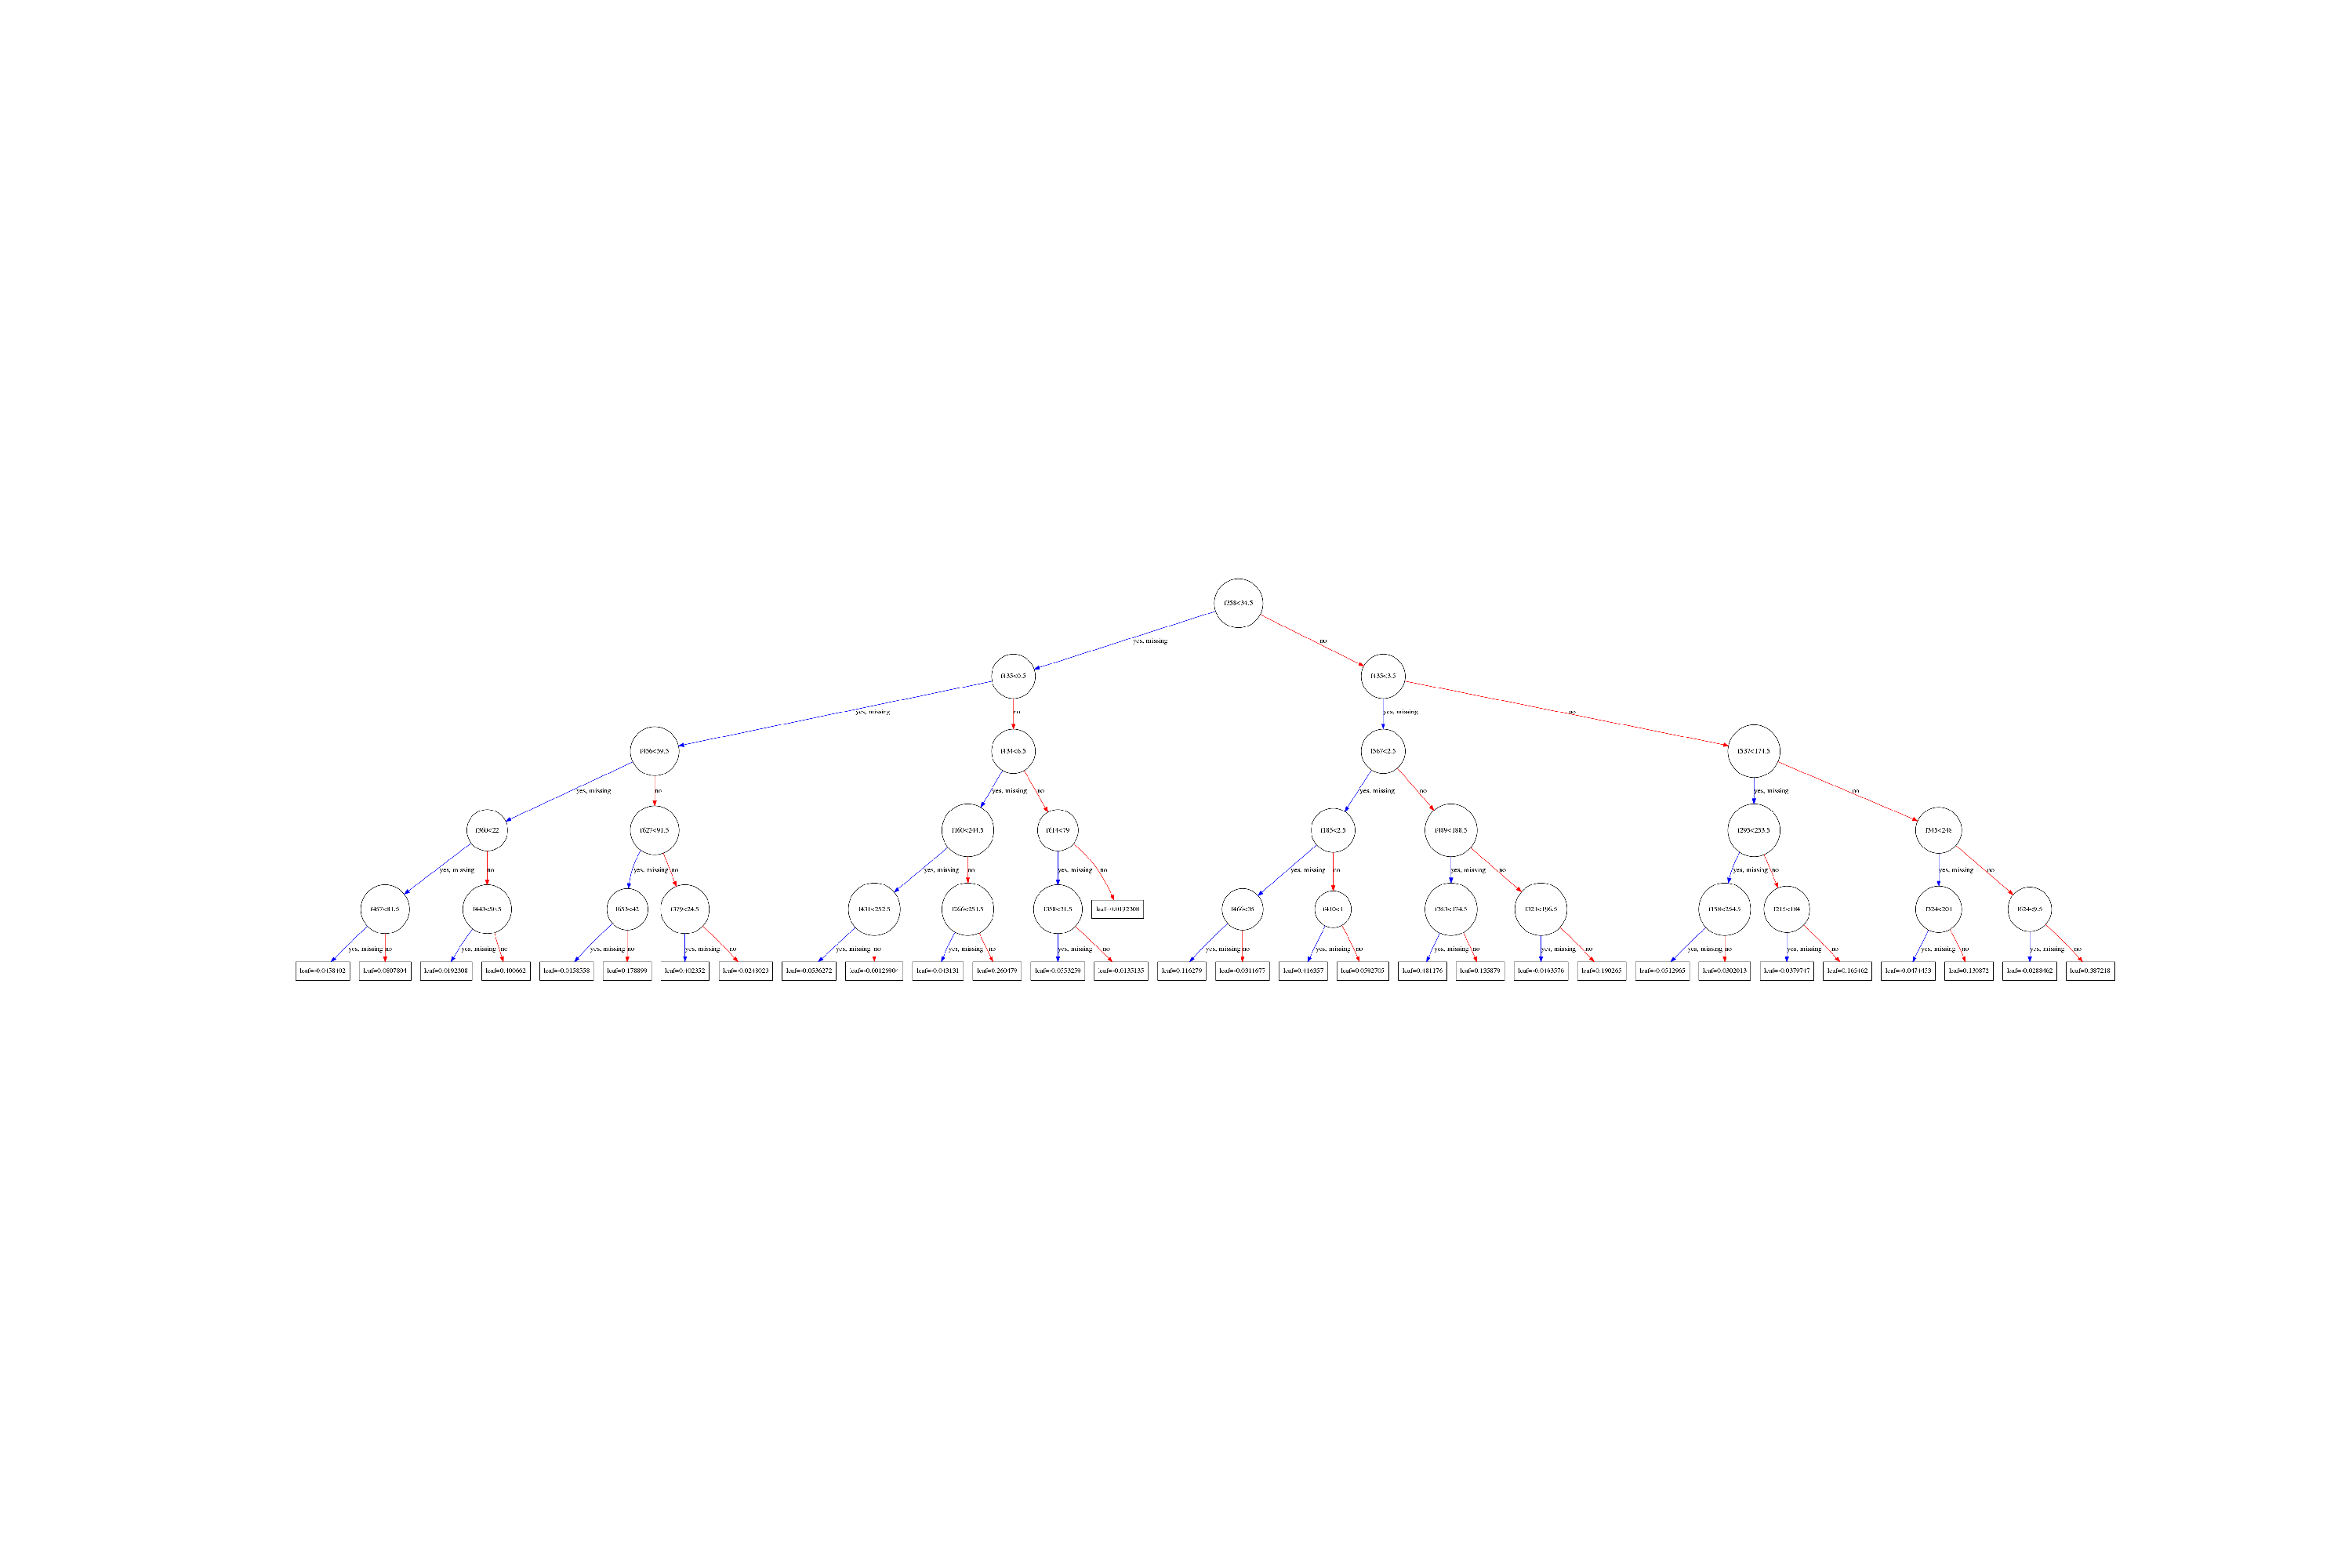

In [15]:
Image('figs/m_tree1.png')

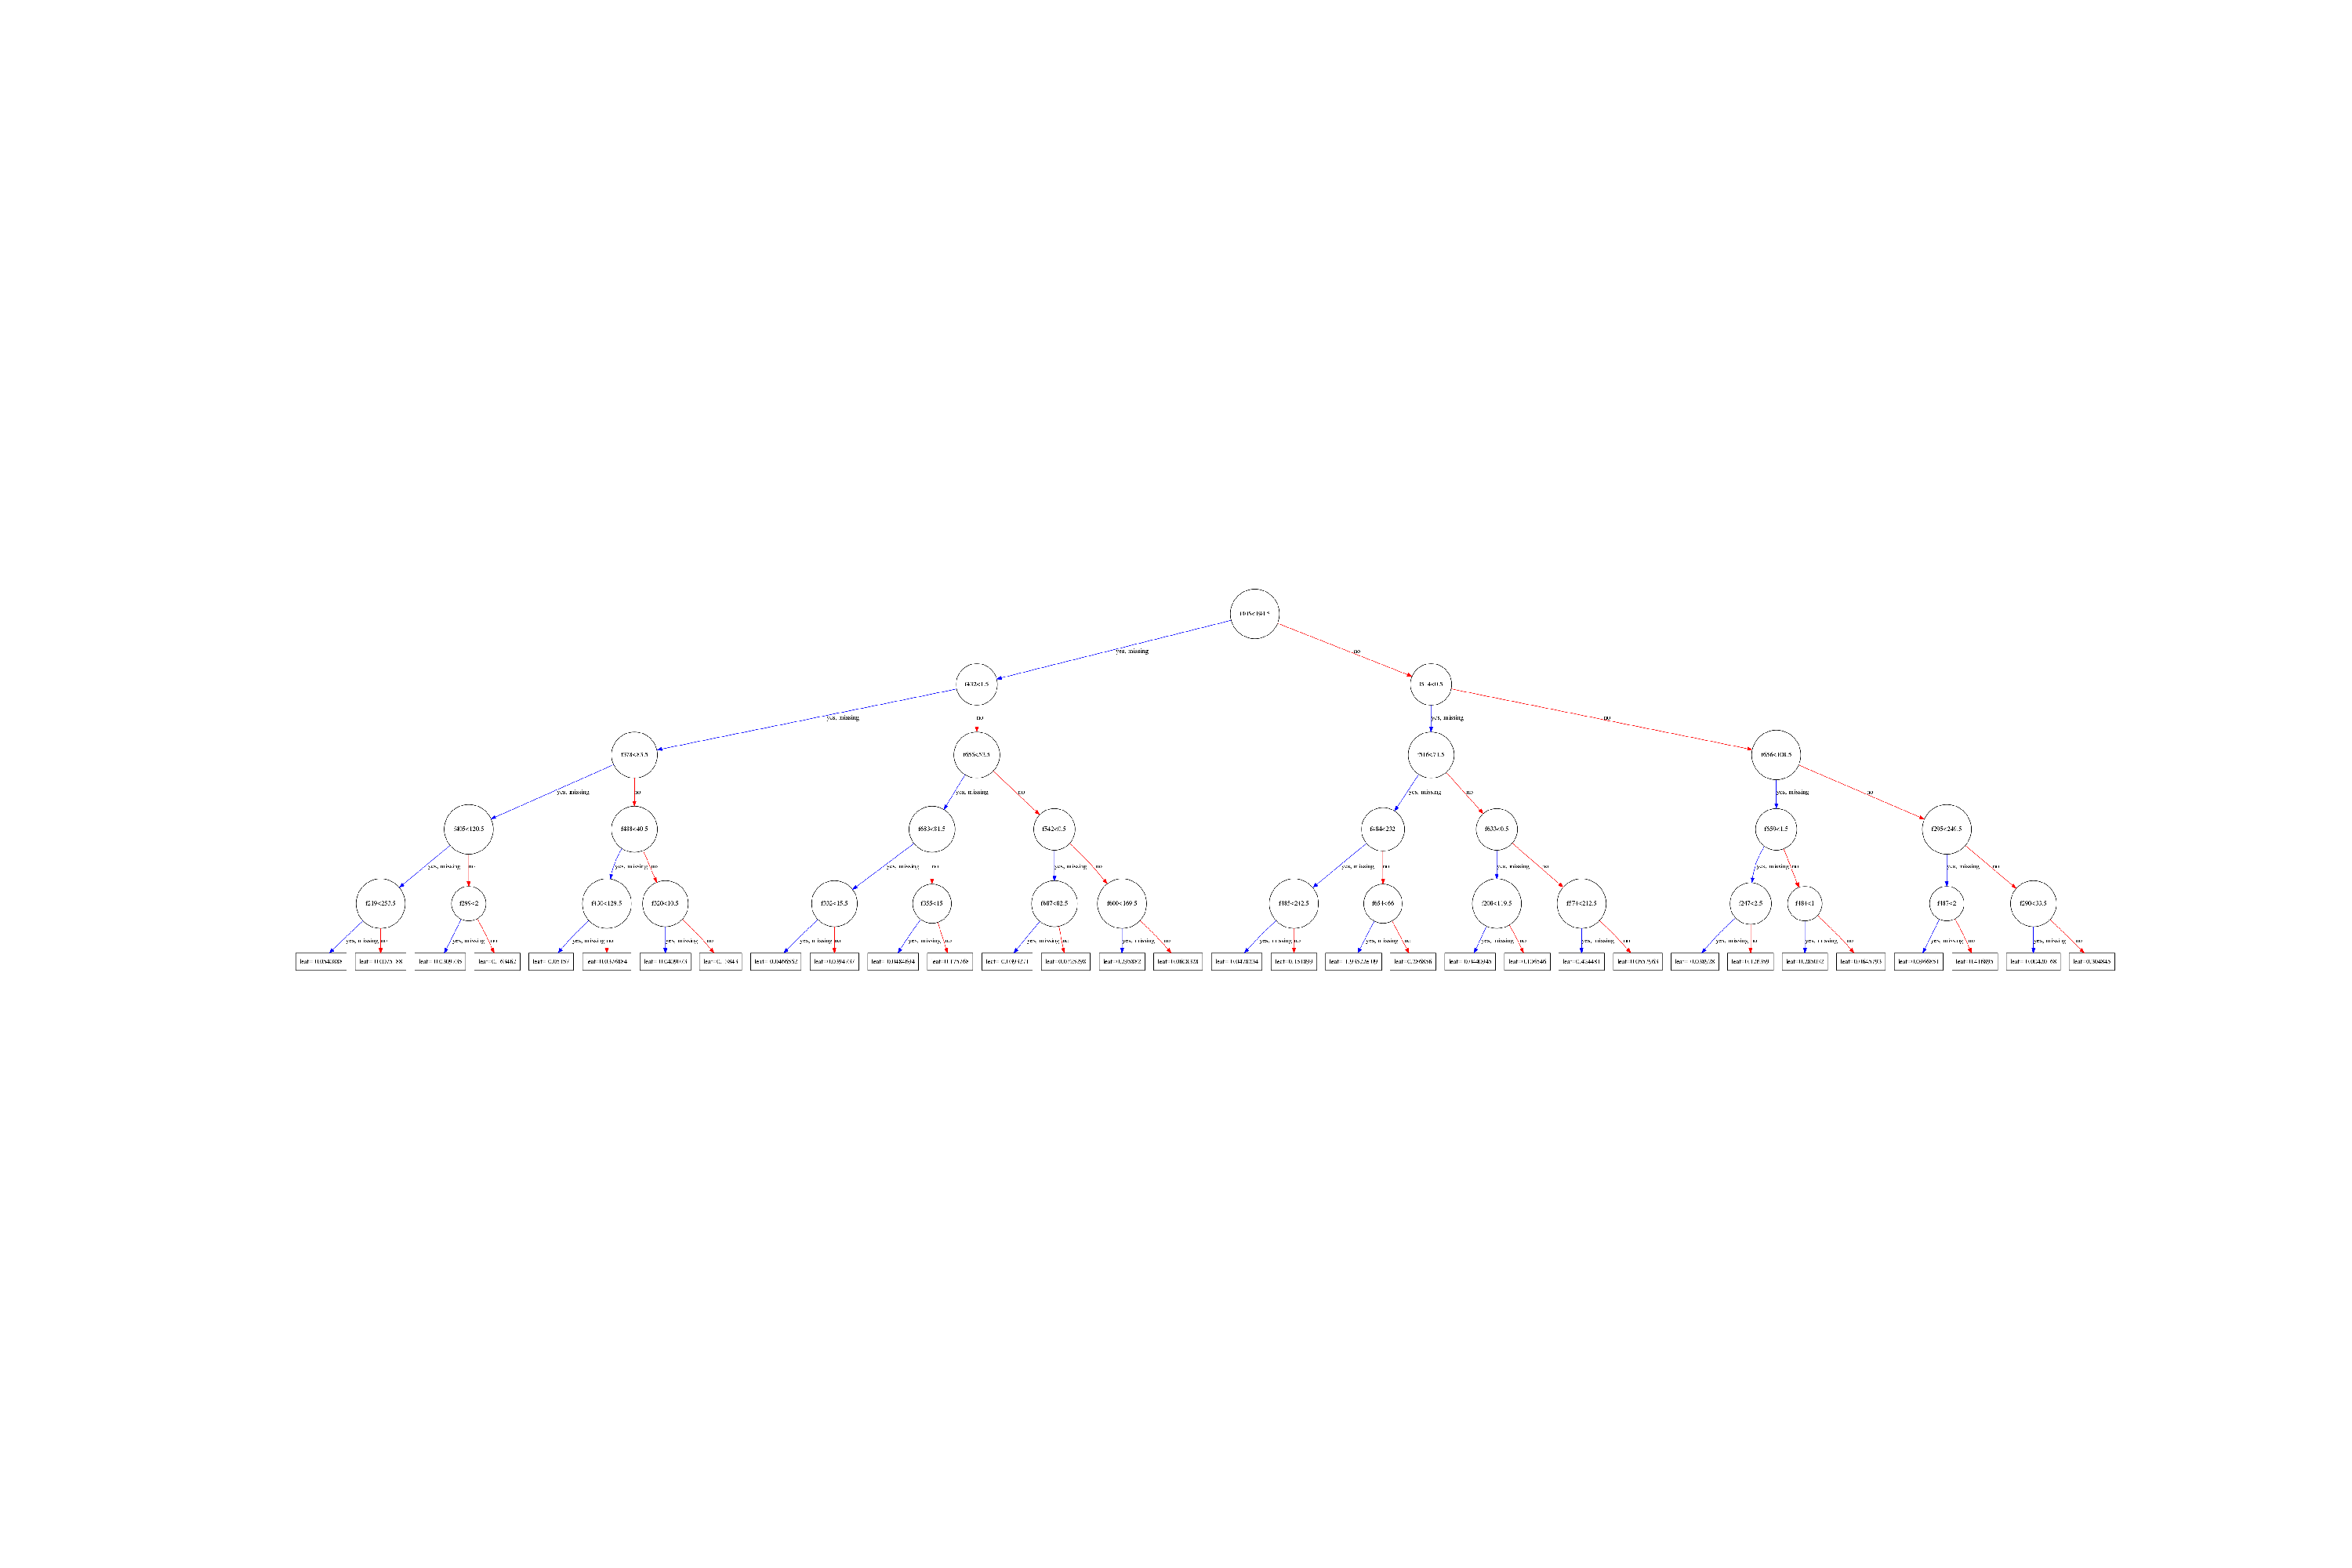

In [16]:
Image('figs/m_tree8.png')

## 输出特征的重要度

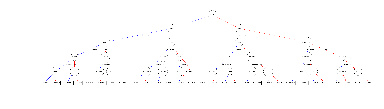

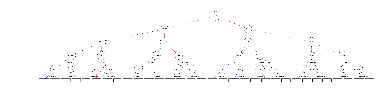

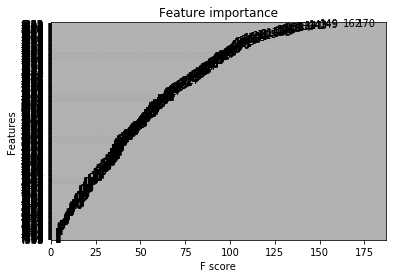

In [14]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(model)
plt.show()